<a href="https://colab.research.google.com/github/yaziciz/IleocolicPedicle/blob/main/Pipeline_PedicleSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ileocolic Pedicle Segmentation

### Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cat /proc/cpuinfo

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.9 MB/s 


In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 


In [ ]:
from tensorflow import optimizers

from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
#from keras import optimizers

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
import segmentation_models as sm
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

from keras.metrics import MeanIoU, Precision, Recall

from keras_unet_collection import models, utils

Segmentation Models: using `keras` framework.


In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

## Dataset Creation

In [ ]:
path = "/content/drive/MyDrive/ITU/Projects/Ileocolic Pedicle Segmentation/Datasets/Medical"

In [ ]:
#Read images and masks

images = []
masks = []

#Read Images
for folder in os.listdir(path):
  for image in sorted(os.listdir(path + "/" + folder + "/images")):
    fullPathImage = path + "/" + folder + "/images/" + image

    temp = cv2.imread(fullPathImage)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    temp = cv2.resize(temp, (224,224))
    images.append(np.array(temp))

for folder in os.listdir(path):
  for mask in sorted(os.listdir(path + "/" + folder + "/masks")):
    fullPathMask = path + "/" + folder + "/masks/" + mask

    tempMask = cv2.imread(fullPathMask, 0)
    tempMask = cv2.resize(tempMask, (224,224))
    tempMask[tempMask > 0] = 255.0
    masks.append(tempMask)

images = np.array(images)
masks = np.array(masks)

In [ ]:
images.shape

(100, 224, 224, 3)

In [ ]:
masks.shape

(100, 224, 224)

In [ ]:
np.unique(masks[80])

array([  0, 255], dtype=uint8)

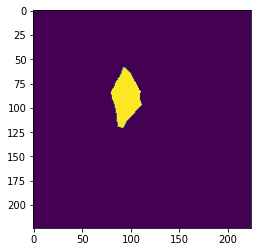

In [ ]:
plt.imshow(masks[80])

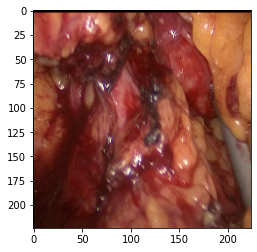

In [ ]:
plt.imshow(images[80])

In [ ]:
masks[40].min()

0

In [ ]:
np.unique(masks)

array([  0, 255], dtype=uint8)

In [ ]:
#Reset the encoded label
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

n, h, w = masks.shape
masks_reshaped = masks.reshape(-1,1)

masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
masks = masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
np.unique(masks)

array([0, 1])

In [ ]:
#Expand dims by one 
#images = np.expand_dims(images, axis = 3)

masks = np.expand_dims(masks, axis = 3).astype('float32')

In [ ]:
#Create subset of the data as training and testing
from sklearn.model_selection import train_test_split
X_train_original, X_rest, y_train, y_rest = train_test_split(images, masks, test_size = 0.40, random_state=seed_value) #Train and rest

In [ ]:
X_test_original, X_val_original, y_test, y_val = train_test_split(X_rest, y_rest, test_size = 0.50, random_state=seed_value) #Validation and test

In [ ]:
X_train = X_train_original.copy().astype('float32')
X_test = X_test_original.copy().astype('float32')
X_val = X_val_original.copy().astype('float32')

In [ ]:
X_train.shape

(60, 224, 224, 3)

## Data Generators

In [ ]:
BACKBONE = 'resnet50'
MODEL = "model_N11"
LR = 0.001
EPOCH = 200
BATCH = 16
PRETRAINED = True

MONITOR = "val_mIoU"
preprocess_input = sm.get_preprocessing(BACKBONE)

Augmentations

In [ ]:
#Datagenerators test samplewise center as well
if(PRETRAINED):
  image_datagenerator = ImageDataGenerator(rotation_range = 5,
                                              shear_range=10,
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            zoom_range = 0.3,
                                            horizontal_flip = True,
                                          fill_mode = 'constant',
                                          preprocessing_function = preprocess_input,
                                           rescale=1/255.)
else:
  image_datagenerator = ImageDataGenerator(rotation_range = 5,
                                            shear_range=10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 0.3,
                                          horizontal_flip = True,
                                         fill_mode = 'constant',
                                         rescale=1/255.)

 
mask_datagenerator = ImageDataGenerator(rotation_range = 5,
                                        shear_range=10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 0.3,
                                          horizontal_flip = True,
                                          preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

debug_datagenerator = ImageDataGenerator()

In [ ]:
#Standardization of the data
mean = np.mean(X_train)  # mean for data centering
std = np.std(X_train)  # std for data normalization
if(not PRETRAINED):
  X_train -= mean
  X_train /= std

  X_test -= mean
  X_test /= std

  X_val -= mean
  X_val /= std

else:
  X_test = preprocess_input(X_test)
  X_val = preprocess_input(X_val)
  
X_test /= 255.
X_val /= 255.

In [ ]:
#Create the generators
image_datagenerator.fit(X_train, augment=True, seed=seed_value)
mask_datagenerator.fit(y_train, augment=True, seed=seed_value)

image_generator = image_datagenerator.flow(X_train, seed=seed_value, batch_size=BATCH, shuffle=True)
mask_generator = mask_datagenerator.flow(y_train, seed=seed_value, batch_size=BATCH, shuffle=True)
train_generator = zip(image_generator, mask_generator)

debug_generator = debug_datagenerator.flow(X_train_original, seed=seed_value, batch_size=BATCH, shuffle=True)

In [ ]:
#Recover an image from standardized version to original
def ReStandardize(img, trainStd, trainMean):
  img *= 255
  img *= trainStd
  img += trainMean
  return np.asarray(img, dtype = np.uint8)

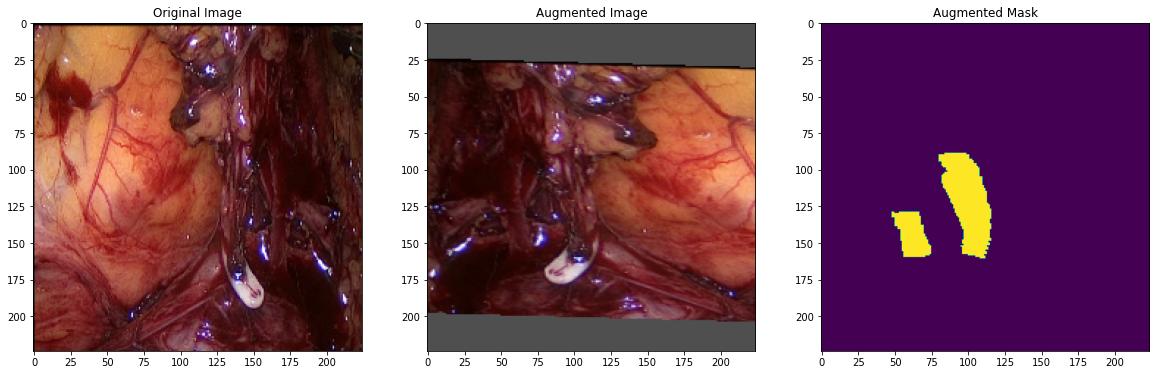

In [ ]:
tempIm = image_generator.next()
tempMask = mask_generator.next()
originalImage = debug_generator.next()

searchIndex = random.randint(0, len(tempIm)-1)
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(np.asarray(originalImage[searchIndex, :,:,]/255., dtype = np.float32))
plt.subplot(132)
plt.title('Augmented Image')
plt.imshow(ReStandardize(tempIm[searchIndex,:,:].copy(), std, mean))
plt.subplot(133)
plt.title('Augmented Mask')
plt.imshow(tempMask[searchIndex,:,:,0])
plt.show()

## Model Creation & Training

In [ ]:
#Attention U-Net
model = models.att_unet_2d((224, 224, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='ResNet50', weights=None, 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name=MODEL)

In [ ]:
#U-Net
if(not PRETRAINED):
  model = sm.Unet(backbone_name=BACKBONE, classes=1, activation='sigmoid', input_shape=(None, None, 3), encoder_weights=None)
else:
  model = sm.Unet(backbone_name=BACKBONE, classes=1, activation='sigmoid')

In [ ]:
#Loss functions
diceLoss = sm.losses.DiceLoss()
jaccardLoss = sm.losses.JaccardLoss()

focalLoss = sm.losses.BinaryFocalLoss()
totalLoss = diceLoss + (1 * focalLoss)

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate = LR), loss=jaccardLoss , metrics=[MeanIoU(num_classes = 2, name = "mIoU"), Precision(name = "precision"), Recall(name = "recall")])

In [ ]:
modelSaver = ModelCheckpoint('/kaggle/working/'+MODEL+'.hdf5', monitor = MONITOR, save_best_only=True, save_weights_only = False, mode = "max")

In [ ]:
reduceLRCallback = ReduceLROnPlateau(factor = 0.8, patience=6, min_lr=1e-5, verbose = 1, monitor = MONITOR, cooldown = 10, mode = 'max')

In [ ]:
model.summary()

Train

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=300 // BATCH, #5 image for each original one.
        epochs=EPOCH,
        validation_data=(X_val, y_val),
        callbacks = [reduceLRCallback, modelSaver],
        verbose = 1)

Store the parameters and history

In [ ]:
#histories = {}
#preds = {}

In [ ]:
import pickle
with open('/kaggle/working/trainHistoryDict_'+MODEL, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
history = pd.read_pickle("/content/drive/MyDrive/ITU/Projects/Ileocolic Pedicle Segmentation/Model/ModelHistories/N/trainHistoryDict_"+MODEL)

In [ ]:
model.load_weights('/content/drive/MyDrive/ITU/Projects/Ileocolic Pedicle Segmentation/Model/SavedModels/N/'+MODEL+'.hdf5')  

In [ ]:
y_test.shape

(20, 224, 224, 1)

## Segmentation Performance

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

1/1 [==============================] - 24s 24s/step


(20, 224, 224, 1)

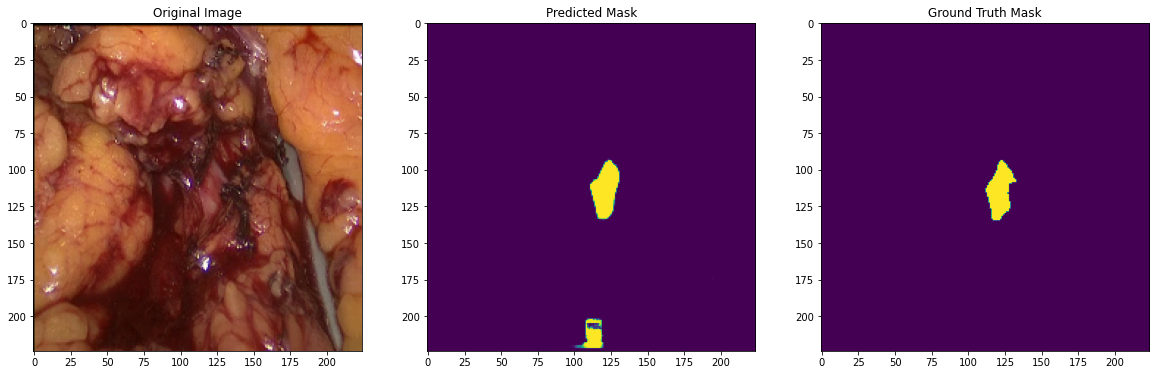

In [ ]:
searchIndex = 4#random.randint(0, len(X_test)-1)
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(X_test_original[searchIndex, :,:,])
plt.subplot(132)
plt.title('Predicted Mask')
plt.imshow(y_pred[searchIndex,:,:,0])
plt.subplot(133)
plt.title('Ground Truth Mask')
plt.imshow(y_test[searchIndex,:,:,0])
plt.show()

Inference Time

In [ ]:
sample = X_test[0,:,:].reshape(1, X_test.shape[1], X_test.shape[2], X_test.shape[3])

In [ ]:
sample.shape

(1, 224, 224, 3)

In [ ]:
import time

start = time.time()
y_pred_temp=model.predict(sample)
end = time.time()

print("Inference time: ", (end-start)*1000)

1/1 [==============================] - 1s 810ms/step
Inference time:  1309.6084594726562


Evaluation Metrics

In [ ]:
IOU_keras = MeanIoU(num_classes = 2)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred[:,:,:,0])
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.91343296


In [ ]:
Precision_keras = Precision()  
Precision_keras.update_state(y_test[:,:,:,0], y_pred[:,:,:,0])
print("Precision =", Precision_keras.result().numpy())

In [ ]:
Recall_keras = Recall()  
Recall_keras.update_state(y_test[:,:,:,0], y_pred[:,:,:,0])
print("Recall =", Recall_keras.result().numpy())

In [ ]:
resultsData = pd.DataFrame(history.history)

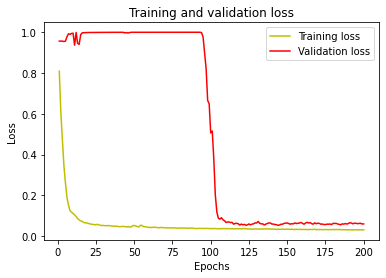

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

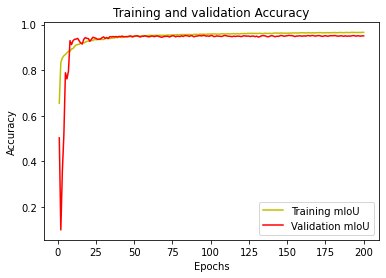

In [ ]:
#plot the training and validation loss and loss at each epoch
acc = history['mIoU']
val_acc = history['val_mIoU']

plt.plot(epochs, acc, 'y', label='Training mIoU')
plt.plot(epochs, val_acc, 'r', label='Validation mIoU')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
"""
from keras.metrics import MeanIoU

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.imshow(y_train[0, :, :, 0], cmap='gray')
"""

In [ ]:
"""
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()
"""

In [ ]:
from sklearn import metrics

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(), y_pred.ravel())

In [ ]:
roc_auc = metrics.auc(fpr,tpr)

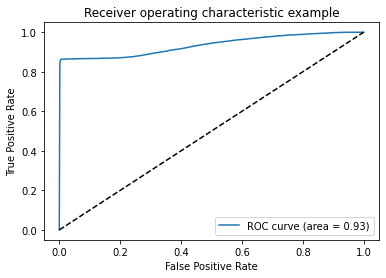

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

In [ ]:
roc_auc

0.9955056037464336